In [50]:
import json
import random
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read files

In [51]:
json_path = "./data/jsons/"

pattern_replace = r"\d+Embed"
pattern_split = r"\n*(\[.+\])\n*"
content = []

for filename in os.listdir(json_path):
    with open(json_path + filename, "r") as f:
        songs = json.load(f)

    artist = filename.split(".")[0].replace("_", " ")
    for song_name, song in songs.items():
        tag = ""
        song_clean = re.sub(pattern=pattern_replace, string=song, repl="")

        for part in re.split(pattern_split, song_clean):
            if re.match(pattern_split, part):
                tag = part
            else:
                content.append((artist, song_name, tag, part))
                tag = ""

In [52]:
df = pd.DataFrame(content, columns=["artist", "song", "tag", "content"])
df

,artist,song,tag,content
0,Shawn Mendes,There’s Nothing Holdin’ Me Back,,146 ContributorsTranslationsEspañolDeutschTher...
1,Shawn Mendes,There’s Nothing Holdin’ Me Back,[Verse 1],I wanna follow where she goes\nI think about h...
2,Shawn Mendes,There’s Nothing Holdin’ Me Back,[Pre-Chorus],She pulls me in enough to keep me guessin' (Mm...
3,Shawn Mendes,There’s Nothing Holdin’ Me Back,[Chorus],"Oh, I've been shaking\nI love it when you go c..."
4,Shawn Mendes,There’s Nothing Holdin’ Me Back,[Verse 2],She says that she's never afraid\nJust picture...
...,...,...,...,...
10140,Backstreet Boys,Larger Than Life,[Chorus: All & AJ],"All you people, can't you see, can't you see\n..."
10141,Backstreet Boys,Larger Than Life,[Bridge: All & AJ],"Ooh-ooh (Yeah)\nOoh-ooh (Ha-ha-ha, that's righ..."
10142,Backstreet Boys,Larger Than Life,[Chorus: All],"All you people, can't you see, can't you see\n..."
10143,Backstreet Boys,Larger Than Life,[Post-Chorus: AJ & (All)],(Yeah) Every time we're down\n(Yeah) You can m...


# Tag Cleansing

In [53]:
def clean(tag):
    pattern = r"\[(.+)\:"
    if ":" in tag:
        match = re.match(pattern, tag)
        if match:
            tag_ = match.group(1)
            return "[" + "".join(filter(lambda x: not x.isdigit(), tag_)).strip() + "]"
    else:
        return "".join(filter(lambda x: not x.isdigit(), tag)).strip()

In [54]:
refine_tags = {
    "[Chorus]": "[Chorus]",
    "[Verse]": "[Verse]",
    "[Bridge]": "[Bridge]",
    "[Intro]": "[Intro]",
    "[Outro]": "[Outro]",
    "[Pre-Chorus]": "[Pre-Chorus]",
    "[Post-Chorus]": "[Post-Chorus]",
    "[Breakdown]": "[Breakdown]",
    "[Verse ]": "[Verse]",
    "[Chorus ]": "[Chorus]",
    "[Instrumental Break]": "[Instrumental Break]",
    "[Post-Bridge]": "[Post-Bridge]",
    "[Pre-Chorus ]": "[Pre-Chorus]",
    "[Refrain]": "[Refrain]",
    "[Interlude]": "[Interlude]",
    "[Spoken Intro]": "[Spoken Intro]",
    "[Spoken Interlude]": "[Spoken Interlude]",
    "[Drop]": "[Drop]",
    "[Vocal bridge]": "[Bridge]",
    "[Album Intro]": "[Album Intro]",
    "[Break]": "[Break]",
    "[Hook]": "[Hook]",
    "[Pré-refrain ]": "[Refrain]",
    "[Couplet ]": "[Couplet]",
    "[Couplet .]": "[Couplet]",
    "[Pre - Chorus]": "[Pre-Chorus]",
    "[Chrous]": "[Chorus]",
    "[Pre-Coro]": "[Pre-Chorus]",
    "[Coro]": "[Chorus]",
    "[Interludio]": "[Interlude]",
    "[Puente]": "[Bridge]",
    "[Verso]": "[Verse]",
    "[Ending]": "[Ending]",
    "[Instrumental Bridge]": "[Bridge]",
}

In [55]:
df["tag_2"] = df["tag"].map(clean)
df = df[df["tag_2"] != ""]
df = df[df["content"] != ""]
df = df[~df[["tag_2", "content"]].isnull().any(axis=1)]
df["tag_2"] = df["tag_2"].map(refine_tags)
df["tag_2"].unique()

array(['[Verse]', '[Pre-Chorus]', '[Chorus]', '[Bridge]', '[Intro]',
       '[Outro]', '[Post-Chorus]', '[Refrain]', '[Breakdown]', nan,
       '[Interlude]', '[Hook]', '[Break]', '[Drop]', '[Spoken Intro]',
       '[Post-Bridge]', '[Spoken Interlude]', '[Instrumental Break]',
       '[Ending]', '[Album Intro]', '[Couplet]'], dtype=object)

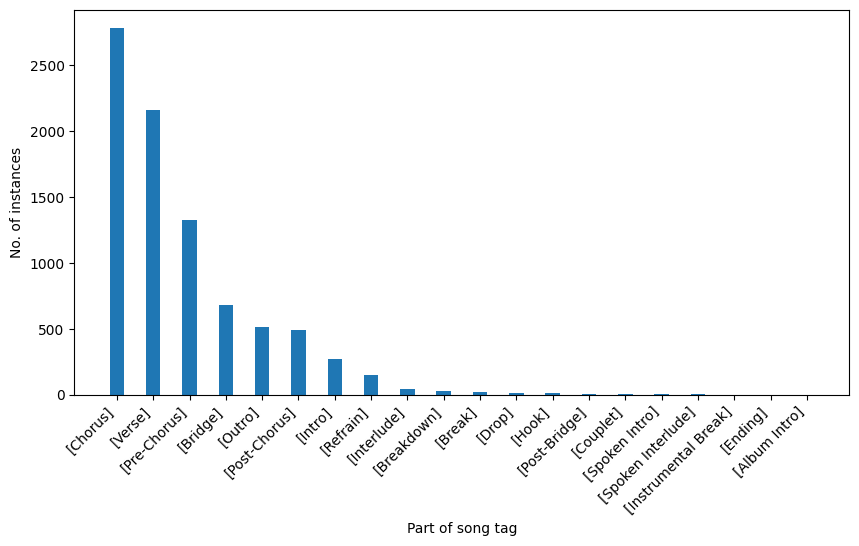

In [56]:
fig = plt.figure(figsize=(10, 5))

plt.bar(
    df["tag_2"].value_counts().keys().to_list(),
    df["tag_2"].value_counts().values,
    width=0.4,
)

plt.xlabel("Part of song tag")
plt.ylabel("No. of instances")
plt.xticks(rotation=45, ha="right")
plt.show()

In [57]:
test_songs = []

random.seed(0)

songs = df[["artist", "song"]].drop_duplicates()
for artist in songs["artist"].unique():
    test_songs.append(random.choice(songs[songs["artist"] == artist]["song"].array))

test_songs[:10]

['Mercy',
 'So Good',
 'Havana',
 'Heaven',
 'Cruel Summer',
 'Medicine',
 'Uh Huh',
 'Can I',
 'Take It Off',
 'Bad Girlfriend']

# Train Test Split

In [58]:
df_test = df[df["song"].isin(test_songs)]
df_train, df_val = train_test_split(df[~df["song"].isin(test_songs)], train_size=0.8)

In [61]:
df_train.sort_values(by=["artist", "song"]).to_csv(
    "./data/datasets/train.csv", index=False
)
df_test.sort_values(by=["artist", "song"]).to_csv(
    "./data/datasets/test.csv", index=False
)
df_val.sort_values(by=["artist", "song"]).to_csv("./data/datasets/val.csv", index=False)